In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
import seaborn as sns

import scipy


In [2]:
PRE_INTERVAL = 1000
POST_INTERVAL = 1000
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "StimOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
SHUFFLE_OUTPUT_DIR = "/data/patrick_res/hyak/pseudo/"
# path to a dataframe of sessions to analyze
matplotlib.rcParams.update({'font.size': 12})


In [4]:
# pairs = pd.read_pickle("/data/patrick_res/sessions/SA/pairs_at_least_3blocks_7sess.pickle")
pairs = pd.read_pickle("/data/patrick_res/sessions/SA/pairs_at_least_3blocks_10sess_more_sess.pickle")

# pairs = pd.read_pickle("/data/patrick_res/sessions/BL/pairs_at_least_2blocks_1sess.pickle")
pairs = pairs.reset_index(drop=True)

### CCGP of belief state value by time

In [5]:
within_dim_accs = []
across_dim_accs = []
overall_accs = []
within_shuffle_accs = []
across_shuffle_accs = []
overall_shuffle_accs = []


sub_pref = "SA_"
for i, (feat1, feat2) in enumerate(pairs.pair.values):
    # if i < 17: 
        name = f"{sub_pref}ccgp_belief_state_value_{EVENT}_pair_{feat1}_{feat2}"
        within_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_within_cond_accs.npy"))
        across_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_across_cond_accs.npy"))
        overall_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_overall_accs.npy"))
        within_dim_accs.append(within_dim_acc)
        across_dim_accs.append(across_dim_acc)
        overall_accs.append(overall_acc)

        shuffle_dir = os.path.join(OUTPUT_DIR, f"{sub_pref}ccgp_belief_state_value_{EVENT}_shuffles")
        for i in range(10): 
            within_shuffle_accs.append(np.load(os.path.join(shuffle_dir, f"{name}_shuffle_{i}_within_cond_accs.npy")))
            across_shuffle_accs.append(np.load(os.path.join(shuffle_dir, f"{name}_shuffle_{i}_across_cond_accs.npy")))
            overall_shuffle_accs.append(np.load(os.path.join(shuffle_dir, f"{name}_shuffle_{i}_overall_accs.npy")))

within_dim_accs = np.hstack(within_dim_accs)
across_dim_accs = np.hstack(across_dim_accs)
overall_accs = np.hstack(overall_accs)

within_shuffle_accs =  np.hstack(within_shuffle_accs)
across_shuffle_accs = np.hstack(across_shuffle_accs)
overall_shuffle_accs = np.hstack(overall_shuffle_accs)

FileNotFoundError: [Errno 2] No such file or directory: '/data/patrick_res/hyak/pseudo/SA_ccgp_belief_state_value_StimOnset_pair_CIRCLE_RIPPLE_within_cond_accs.npy'

ValueError: Must pass 2-d input. shape=(3, 20, 8)

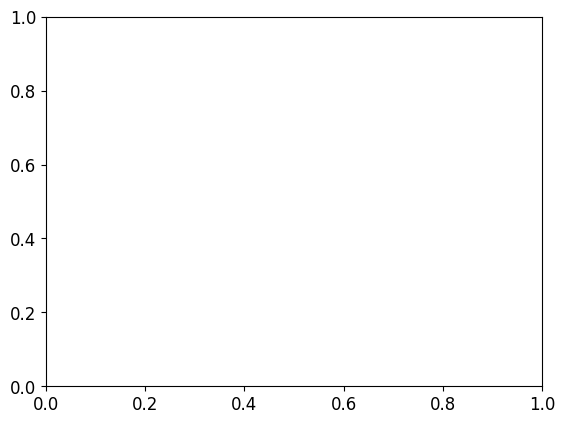

In [6]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn(
    [overall_accs, overall_shuffle_accs], 
    ["Belief State Value", "Shuffle"], 
    500, 100, ax)
ax.axvline(0.5, alpha=0.3, color='gray', linestyle='dashed', label="Stimulus Onset")

# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Cross Fixation (s)")


Text(0.5, 0, 'Time Relative to Stimulus Onset (s)')

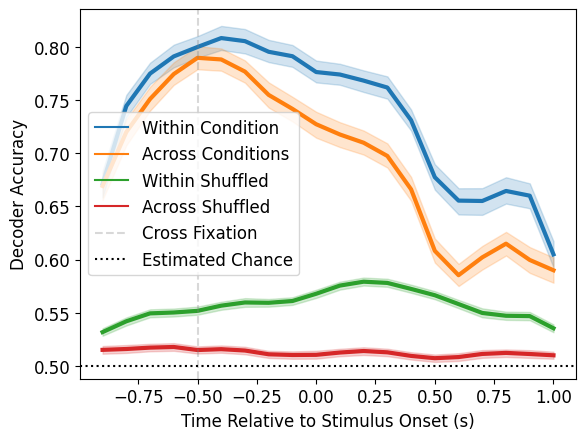

In [13]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn(
    [within_dim_accs, across_dim_accs, within_shuffle_accs, across_shuffle_accs], 
    ["Within Condition", "Across Conditions", "Within Shuffled", "Across Shuffled"], 
    PRE_INTERVAL, INTERVAL_SIZE, ax)
ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed', label="Cross Fixation")
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Stimulus Onset (s)")


### Cross (time) decoding for overall, within condition models

Text(0, 0.5, 'Time Model Trained (s)')

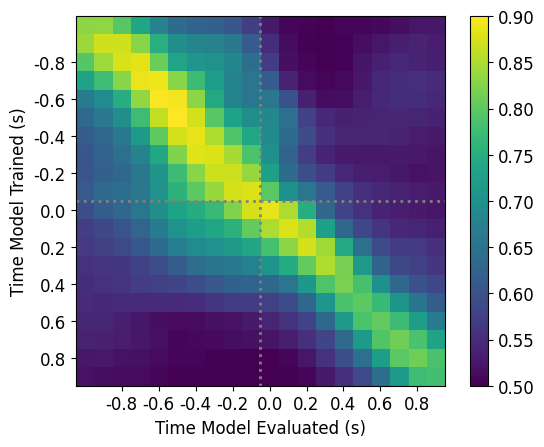

In [7]:
fig, ax = plt.subplots()
all_accs = []
for (feat1, feat2) in pairs.pair.values:
    feat1_cross_accs = np.load(os.path.join(OUTPUT_DIR, f"ccgp_belief_state_value_StimOnset_pair_{feat1}_{feat2}_feat_{feat1}_cross_accs.npy"))
    feat2_cross_accs = np.load(os.path.join(OUTPUT_DIR, f"ccgp_belief_state_value_StimOnset_pair_{feat1}_{feat2}_feat_{feat2}_cross_accs.npy"))
    all_accs.append(feat1_cross_accs)
    all_accs.append(feat2_cross_accs)
all_accs = np.concatenate(all_accs, axis=2)
all_accs = np.mean(all_accs, axis=2)
colors = ax.matshow(all_accs)
colors.set_clim(0.5, 0.9)
fig.colorbar(colors, ax=ax)
ratio = 1000 / 100
# tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_labels = np.array([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
tick_pos = (tick_labels + 1) * ratio
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
# ax.axvline(4.5, color="gray", linestyle="dotted", linewidth=2)
# ax.axhline(4.5, color="gray", linestyle="dotted", linewidth=2)
ax.axvline(9.5, color="gray", linestyle="dotted", linewidth=2)
ax.axhline(9.5, color="gray", linestyle="dotted", linewidth=2)
ax.set_xlabel("Time Model Evaluated (s)")
ax.set_ylabel("Time Model Trained (s)")

Text(0, 0.5, 'Time Model Trained (s)')

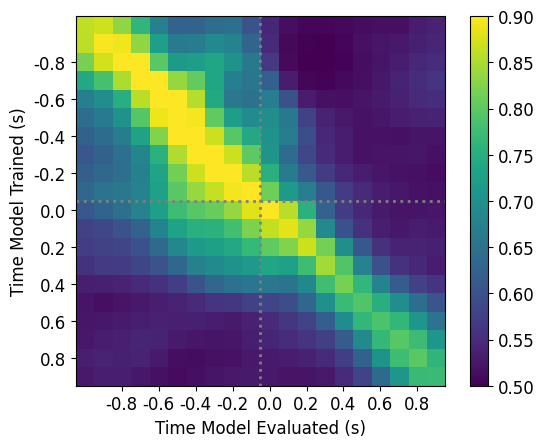

In [8]:
fig, ax = plt.subplots()
all_accs = []
for (feat1, feat2) in pairs.pair.values:
    cross_accs = np.load(os.path.join(OUTPUT_DIR, f"ccgp_belief_state_value_StimOnset_pair_{feat1}_{feat2}_overall_cross_accs.npy"))
    all_accs.append(cross_accs)
all_accs = np.concatenate(all_accs, axis=2)
all_accs = np.mean(all_accs, axis=2)
colors = ax.matshow(all_accs)
colors.set_clim(0.5, 0.9)
fig.colorbar(colors, ax=ax)
ratio = 1000 / 100
# tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_labels = np.array([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
tick_pos = (tick_labels + 1) * ratio
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
# ax.axvline(4.5, color="gray", linestyle="dotted", linewidth=2)
# ax.axhline(4.5, color="gray", linestyle="dotted", linewidth=2)
ax.axvline(9.5, color="gray", linestyle="dotted", linewidth=2)
ax.axhline(9.5, color="gray", linestyle="dotted", linewidth=2)
ax.set_xlabel("Time Model Evaluated (s)")
ax.set_ylabel("Time Model Trained (s)")

### Cosyne 2025 Figure

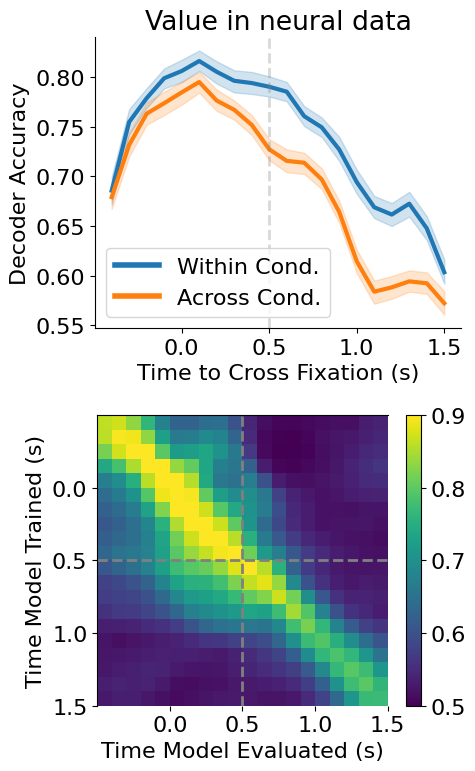

In [9]:
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2, 1, figsize=(5, 8))
ax = axs[0]
visualization_utils.plot_accs_seaborn(
    # [overall_accs, within_dim_accs, across_dim_accs, ], 
    # ["Overall", "Within Cond.", "Across Cond."], 
    [within_dim_accs, across_dim_accs, ], 
    ["Within Cond.", "Across Cond."], 
    500, 100, ax)
ax.legend()
for line in ax.legend().get_lines():
    line.set_linewidth(4)
# # add estimated chance
ax.axvline(0.5, alpha=0.3, color='gray', linestyle='dashed', linewidth=2)
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time to Cross Fixation (s)")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title("Value in neural data")

# plt.rcParams.update({'font.size': 14})
ax = axs[1]
colors = ax.matshow(all_accs)
colors.set_clim(0.5, 0.9)
fig.colorbar(colors, ax=ax)
ratio = 1000 / 100
# tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
# tick_labels = np.array([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
tick_labels = np.array([0, 0.5, 1.0, 1.5])

tick_pos = (tick_labels + 0.45) * ratio
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
# ax.axvline(4.5, color="gray", linestyle="dotted", linewidth=2)
# ax.axhline(4.5, color="gray", linestyle="dotted", linewidth=2)
ax.axvline(9.5, color="gray", linestyle="dashed", linewidth=2)
ax.axhline(9.5, color="gray", linestyle="dashed", linewidth=2)
ax.set_xlabel("Time Model Evaluated (s)")
ax.set_ylabel("Time Model Trained (s)")
ax.spines[['bottom', 'right']].set_visible(False)


fig.tight_layout()

fig.savefig("/data/patrick_res/figures/2025_cosyne_abstract/belief_state_value_ccgp_cross.svg")



### 2025 FADEx Poster Figure

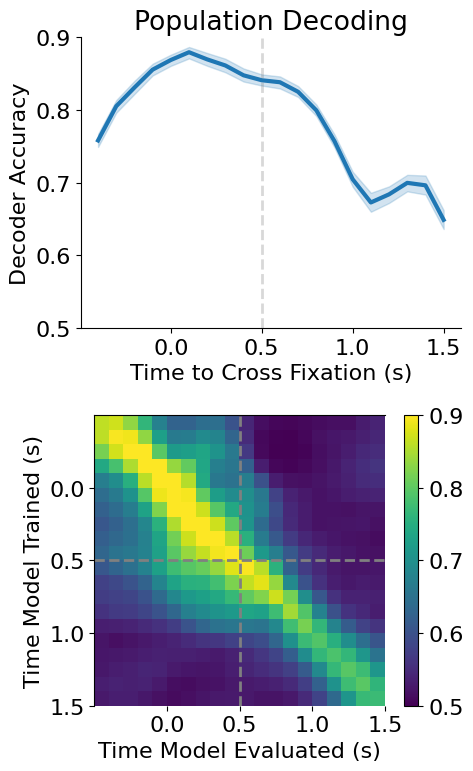

In [10]:
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2, 1, figsize=(5, 8))
ax = axs[0]
visualization_utils.plot_accs_seaborn(
    # [overall_accs, within_dim_accs, across_dim_accs, ], 
    # ["Overall", "Within Cond.", "Across Cond."], 
    [overall_accs], 
    [""], 
    500, 100, ax)
# ax.legend()
# for line in ax.legend().get_lines():
#     line.set_linewidth(4)
# # add estimated chance
ax.axvline(0.5, alpha=0.3, color='gray', linestyle='dashed', linewidth=2)
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time to Cross Fixation (s)")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title("Population Decoding")
ax.set_ylim([0.5, 0.9])
ax.set_yticks([.5, .6, .7, .8, .9])
ax.set_yticklabels([.5, .6, .7, .8, .9])

# plt.rcParams.update({'font.size': 14})
ax = axs[1]
colors = ax.matshow(all_accs)
colors.set_clim(0.5, 0.9)
fig.colorbar(colors, ax=ax)
ratio = 1000 / 100
# tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
# tick_labels = np.array([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
tick_labels = np.array([0, 0.5, 1.0, 1.5])

tick_pos = (tick_labels + 0.45) * ratio
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
# ax.axvline(4.5, color="gray", linestyle="dotted", linewidth=2)
# ax.axhline(4.5, color="gray", linestyle="dotted", linewidth=2)
ax.axvline(9.5, color="gray", linestyle="dashed", linewidth=2)
ax.axhline(9.5, color="gray", linestyle="dashed", linewidth=2)
ax.set_xlabel("Time Model Evaluated (s)")
ax.set_ylabel("Time Model Trained (s)")
ax.spines[['bottom', 'right']].set_visible(False)


fig.tight_layout()

fig.savefig("/data/patrick_res/figures/2025_fadex_poster/bsv_decoding.svg")



### 2025 FADEx, CCGP

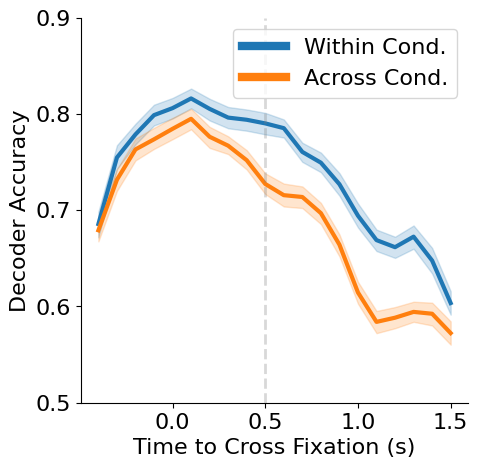

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
visualization_utils.plot_accs_seaborn(
    # [overall_accs, within_dim_accs, across_dim_accs, ], 
    # ["Overall", "Within Cond.", "Across Cond."], 
    [within_dim_accs, across_dim_accs, ], 
    ["Within Cond.", "Across Cond."], 
    500, 100, ax)
for line in ax.legend().get_lines():
    line.set_linewidth(6)
# # add estimated chance
ax.axvline(0.5, alpha=0.3, color='gray', linestyle='dashed', linewidth=2)
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time to Cross Fixation (s)")
ax.set_ylim([0.5, 0.9])
ax.set_yticks([.5, .6, .7, .8, .9])
ax.set_yticklabels([.5, .6, .7, .8, .9])
ax.spines[['right', 'top']].set_visible(False)
fig.savefig("/data/patrick_res/figures/2025_fadex_poster/ccgp_crossfix.svg")


### Look at within vs. across dim accuracies separately
10 pairs across dim, 8 pairs within dim

In [12]:
pairs

,pair,sessions,num_sessions,dim_type
0,"[CIRCLE, SQUARE]","[20180709, 20180802, 20180803, 20180806, 20180...",8,within dim
1,"[CIRCLE, GREEN]","[20180802, 20180806, 20180808, 20180921, 20180...",7,across dim
2,"[CIRCLE, YELLOW]","[20180802, 20180918, 20180921, 20180924, 20181...",7,across dim
3,"[SQUARE, TRIANGLE]","[20180801, 20180802, 20180803, 20180806, 20180...",7,within dim
4,"[SQUARE, GREEN]","[20180802, 20180806, 20180808, 20180924, 20180...",7,across dim
5,"[SQUARE, MAGENTA]","[20180801, 20180802, 20180803, 20180806, 20180...",7,across dim
6,"[SQUARE, YELLOW]","[20180801, 20180802, 20180924, 20180925, 20180...",7,across dim
7,"[SQUARE, POLKADOT]","[20180709, 20180802, 20180803, 20180808, 20180...",7,across dim
8,"[STAR, POLKADOT]","[20180709, 20180803, 20180917, 20180920, 20180...",7,across dim
9,"[CYAN, GREEN]","[20180802, 20180910, 20180912, 20180921, 20180...",7,within dim


In [8]:
within_dim_within_cond_accs = []
within_dim_across_cond_accs = []

across_dim_within_cond_accs = []
across_dim_across_cond_accs = []

for _, row in pairs.iterrows():
    feat1, feat2 = row.pair
    within_cond_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_belief_state_value_{EVENT}_pair_{feat1}_{feat2}_within_cond_accs.npy"))
    across_cond_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_belief_state_value_{EVENT}_pair_{feat1}_{feat2}_across_cond_accs.npy"))
    if row.dim_type == "within dim":
        within_dim_within_cond_accs.append(within_cond_acc)
        within_dim_across_cond_accs.append(across_cond_acc)
    elif row.dim_type == "across dim":
        across_dim_within_cond_accs.append(within_cond_acc)
        across_dim_across_cond_accs.append(across_cond_acc)
    else: 
        raise ValueError()

within_dim_within_cond_accs = np.hstack(within_dim_within_cond_accs)
within_dim_across_cond_accs = np.hstack(within_dim_across_cond_accs)
across_dim_within_cond_accs = np.hstack(across_dim_within_cond_accs)
across_dim_across_cond_accs = np.hstack(across_dim_across_cond_accs)


Text(0.5, 1.0, 'Cross condition accs, by across or within dimensions')

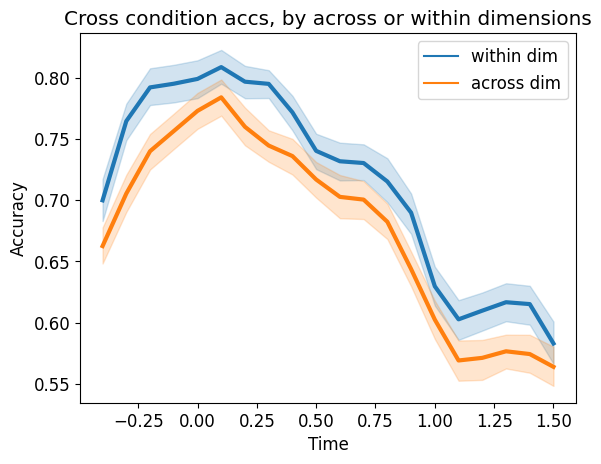

In [15]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn(
    # [overall_accs, within_dim_accs, across_dim_accs, ], 
    # ["Overall", "Within Cond.", "Across Cond."], 
    # [within_dim_within_cond_accs, within_dim_across_cond_accs, across_dim_within_cond_accs, across_dim_across_cond_accs], 
    # ["within dim within cond.", "within dim across cond", "across dim within cond", "across dim across cond"], 
    [within_dim_across_cond_accs, across_dim_across_cond_accs], 
    ["within dim", "across dim"], 
    500, 100, ax)
ax.legend()
ax.set_title("Cross condition accs, by across or within dimensions")

Text(0.5, 1.0, 'Within cond accs, by across or within dimensions')

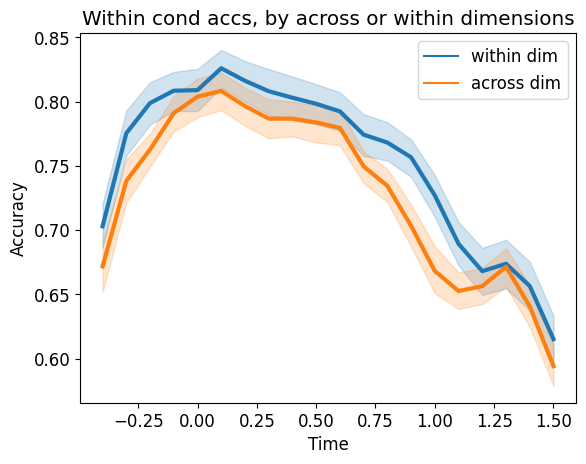

In [16]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn(
    # [overall_accs, within_dim_accs, across_dim_accs, ], 
    # ["Overall", "Within Cond.", "Across Cond."], 
    # [within_dim_within_cond_accs, within_dim_across_cond_accs, across_dim_within_cond_accs, across_dim_across_cond_accs], 
    # ["within dim within cond.", "within dim across cond", "across dim within cond", "across dim across cond"], 
    [within_dim_within_cond_accs, across_dim_within_cond_accs], 
    ["within dim", "across dim"], 
    500, 100, ax)
ax.legend()
ax.set_title("Within cond accs, by across or within dimensions")

In general, could just be that there's more/better data in the within dim pairs. need to balance better
- coarse data point: on average, there's 7.1 sessions per pair for across dim, 7.7 for within dim

How should we balance: want to balance number of trials (data points) and number of units (features)
- across all pairs, look at all sessions, find min number of units for pair. This is the number of units that will be subselected. 
- across all pairs, for each session, across each condition, look at minimum number of trials present. This should be number of trials that is sub-sampled. 

In [21]:
pairs.groupby("dim_type").mean()

/tmp/ipykernel_2623181/1035511158.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pairs.groupby("dim_type").mean()


,num_sessions
dim_type,
across dim,7.10
within dim,7.75


### If CCGP was split by anterior vs. temporal drives

In [12]:
regions = ["temporal", "anterior"]
conds = ["within_cond", "across_cond", "overall"]
res = []
for region in regions: 
    for cond in conds:  
        for (feat1, feat2) in pairs.pair.values:
            acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_belief_state_value_{EVENT}_pair_{feat1}_{feat2}_{region}_{cond}_accs.npy"))
            df = pd.DataFrame(acc).reset_index(names=["Time"])
            df["Time"] = (df["Time"] * INTERVAL_SIZE + INTERVAL_SIZE - 500) / 1000
            df = df.melt(id_vars="Time", value_vars=list(range(acc.shape[1])), var_name="run", value_name="Accuracy")
            # df["pair"] = feat1, feat2
            df["region"] = region
            df["condition"] = cond
            res.append(df)
res = pd.concat(res)

Text(0.5, 1.0, 'Belief State Value Overall split by region')

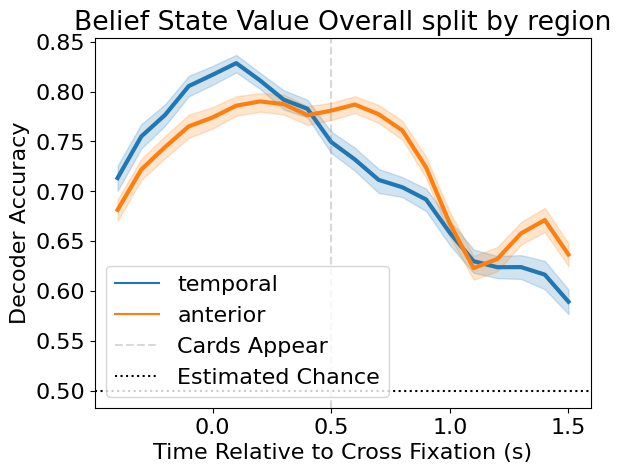

In [17]:
fig, ax = plt.subplots()
overalls = res[res.condition == "overall"]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="region", linewidth=3, ax=ax)
ax.axvline(0.5, alpha=0.3, color='gray', linestyle='dashed', label="Cards Appear")
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Cross Fixation (s)")
ax.set_title("Belief State Value Overall split by region")


Text(0.5, 1.0, 'Belief State Value within cond split by region')

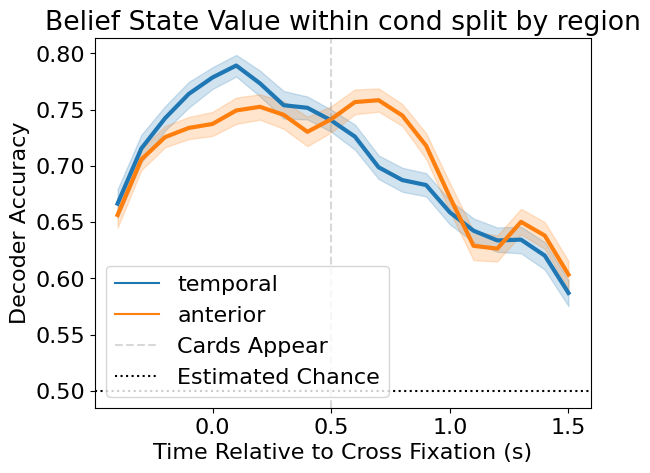

In [18]:
fig, ax = plt.subplots()
within_conds = res[res.condition == "within_cond"]
sns.lineplot(within_conds, x="Time", y="Accuracy", hue="region", linewidth=3, ax=ax)
ax.axvline(0.5, alpha=0.3, color='gray', linestyle='dashed', label="Cards Appear")
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Cross Fixation (s)")
ax.set_title("Belief State Value within cond split by region")

Text(0.5, 1.0, 'Belief State Value anterior')

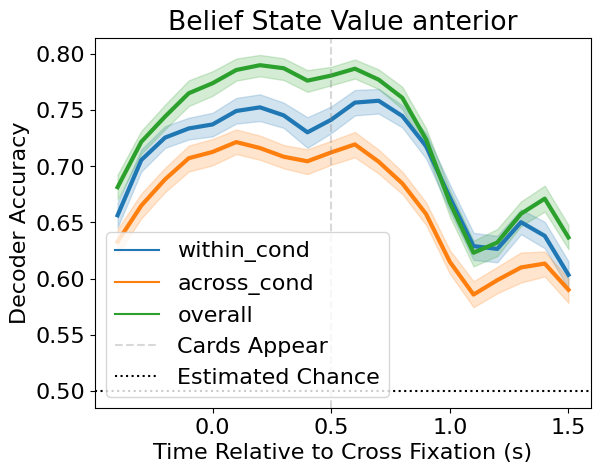

In [19]:
fig, ax = plt.subplots()
anterior = res[res.region == "anterior"]
sns.lineplot(anterior, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
ax.axvline(0.5, alpha=0.3, color='gray', linestyle='dashed', label="Cards Appear")
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Cross Fixation (s)")
ax.set_title("Belief State Value anterior")


Text(0.5, 1.0, 'Belief State Value temporal')

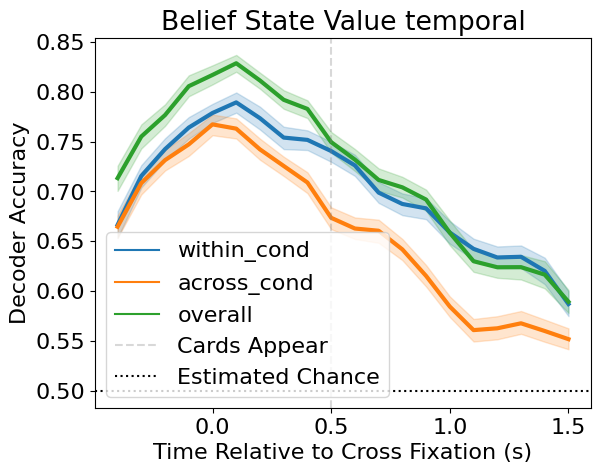

In [21]:
fig, ax = plt.subplots()
temporal = res[res.region == "temporal"]
sns.lineplot(temporal, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
ax.axvline(0.5, alpha=0.3, color='gray', linestyle='dashed', label="Cards Appear")
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Cross Fixation (s)")
ax.set_title("Belief State Value temporal")


### Cross time decoding, split by anterior, temporal

In [9]:
cross_accs_by_region = {}
for region in ["anterior", "temporal"]: 
    all_accs = []
    for (feat1, feat2) in pairs.pair.values:
        feat1_cross_accs = np.load(os.path.join(OUTPUT_DIR, f"ccgp_belief_state_value_StimOnset_pair_{feat1}_{feat2}_{region}_feat_{feat1}_cross_accs.npy"))
        feat2_cross_accs = np.load(os.path.join(OUTPUT_DIR, f"ccgp_belief_state_value_StimOnset_pair_{feat1}_{feat2}_{region}_feat_{feat2}_cross_accs.npy"))
        all_accs.append(feat1_cross_accs)
        all_accs.append(feat2_cross_accs)
    all_accs = np.concatenate(all_accs, axis=2)
    all_accs = np.mean(all_accs, axis=2)
    cross_accs_by_region[region] = all_accs

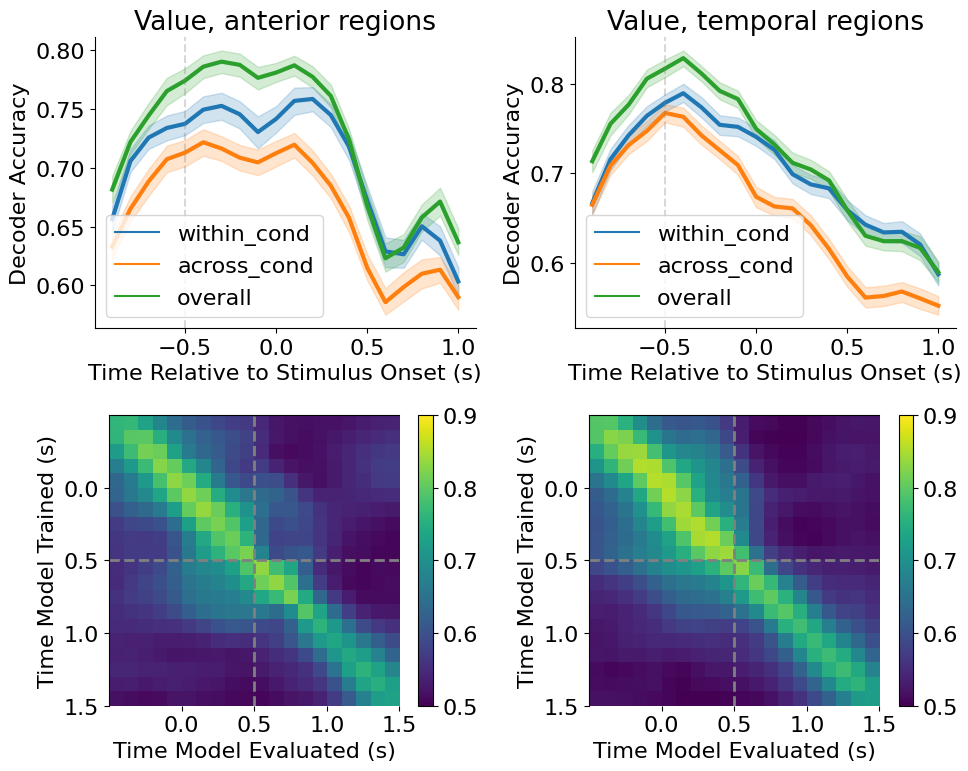

In [11]:
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, region in enumerate(["anterior", "temporal"]):
    ax = axs[0, i]
    ccgp = res[res.region == region]
    sns.lineplot(ccgp, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
    ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed')
    # # add estimated chance
    # ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
    ax.legend()
    ax.set_ylabel("Decoder Accuracy")
    ax.set_xlabel("Time Relative to Stimulus Onset (s)")
    ax.set_title(f"Belief State Value CCGP {region}")
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_title(f"Value, {region} regions")

    # plt.rcParams.update({'font.size': 14})
    ax = axs[1, i]
    colors = ax.matshow(cross_accs_by_region[region])
    colors.set_clim(0.5, 0.9)
    fig.colorbar(colors, ax=ax)
    ratio = 1000 / 100
    # tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
    # tick_labels = np.array([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
    tick_labels = np.array([0, 0.5, 1.0, 1.5])

    tick_pos = (tick_labels + 0.45) * ratio
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels)
    ax.xaxis.tick_bottom()
    ax.set_yticks(tick_pos)
    ax.set_yticklabels(tick_labels)
    # ax.axvline(4.5, color="gray", linestyle="dotted", linewidth=2)
    # ax.axhline(4.5, color="gray", linestyle="dotted", linewidth=2)
    ax.axvline(9.5, color="gray", linestyle="dashed", linewidth=2)
    ax.axhline(9.5, color="gray", linestyle="dashed", linewidth=2)
    ax.set_xlabel("Time Model Evaluated (s)")
    ax.set_ylabel("Time Model Trained (s)")
    ax.spines[['bottom', 'right']].set_visible(False)


fig.tight_layout()



### Is there a difference when conditioning on prev trial's feedback

In [4]:
regions = ["temporal", "anterior", None]
conds = ["within_cond", "across_cond", "overall"]
prev_responses = ["Correct", "Incorrect"]
res = []
for region in regions: 
    for cond in conds:  
        for (feat1, feat2) in pairs.pair.values:
            for prev_response in prev_responses: 
                region_str = "" if region is None else f"_{region}"
                prev_res_str = "" if prev_response is None else f"_prev_res_{prev_response}"

                acc = np.load(os.path.join(OUTPUT_DIR, f"SA_ccgp_belief_state_value_{EVENT}_pair_{feat1}_{feat2}{region_str}{prev_res_str}_{cond}_accs.npy"))
                df = pd.DataFrame(acc).reset_index(names=["Time"])
                df["Time"] = (df["Time"] * INTERVAL_SIZE + INTERVAL_SIZE - 500) / 1000
                df = df.melt(id_vars="Time", value_vars=list(range(acc.shape[1])), var_name="run", value_name="Accuracy")
                # df["pair"] = feat1, feat2
                df["region"] = region
                df["condition"] = cond
                df["prev_response"] = prev_response
                res.append(df)
res = pd.concat(res)

In [5]:
def set_labels(ax):
    ax.axvline(0.5, alpha=0.3, color='gray', linestyle='dashed', label="Cards Appear")
    # # add estimated chance
    ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
    ax.legend()
    ax.set_ylabel("Decoder Accuracy")
    ax.set_xlabel("Time Relative to Cross Fixation (s)")

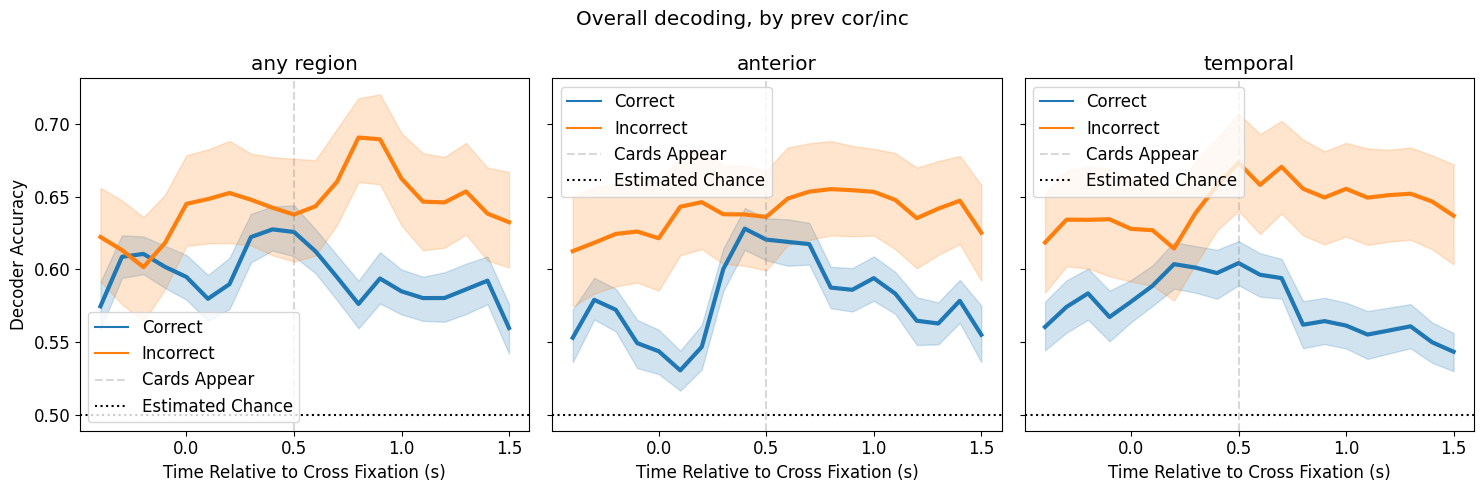

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax = axs[0]
sub = res[(res.region.isna()) & (res.condition == "overall")]
sns.lineplot(sub, x="Time", y="Accuracy", hue="prev_response", linewidth=3, ax=ax)
set_labels(ax)
ax.set_title("any region")

ax = axs[1]
sub = res[(res.region == "anterior") & (res.condition == "overall")]
sns.lineplot(sub, x="Time", y="Accuracy", hue="prev_response", linewidth=3, ax=ax)
set_labels(ax)
ax.set_title("anterior")

ax = axs[2]
sub = res[(res.region == "temporal") & (res.condition == "overall")]
sns.lineplot(sub, x="Time", y="Accuracy", hue="prev_response", linewidth=3, ax=ax)
set_labels(ax)

ax.set_title("temporal")
fig.suptitle("Overall decoding, by prev cor/inc")
fig.tight_layout()


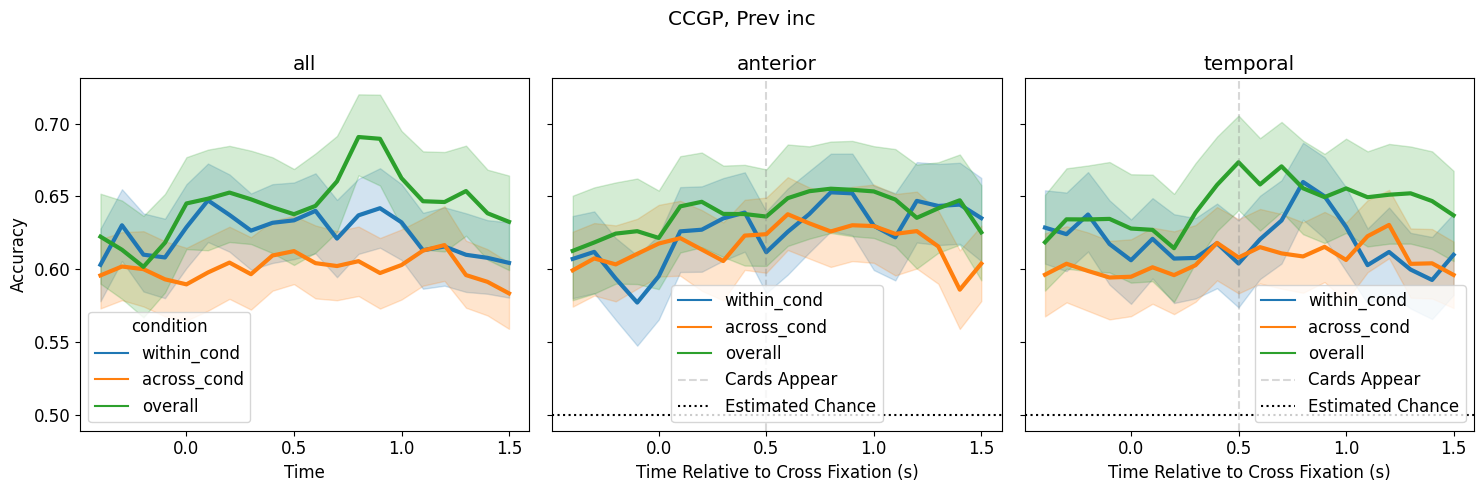

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

ax = axs[0]
sub = res[(res.region.isna()) & (res.prev_response == "Incorrect")]
sns.lineplot(sub, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
ax.set_title("all")

ax = axs[1]
sub = res[(res.region == "anterior") & (res.prev_response == "Incorrect")]
sns.lineplot(sub, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
set_labels(ax)
ax.set_title("anterior")

ax = axs[2]
sub = res[(res.region == "temporal") & (res.prev_response == "Incorrect")]
sns.lineplot(sub, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
set_labels(ax)
ax.set_title("temporal")

fig.suptitle("CCGP, Prev inc")
fig.tight_layout()


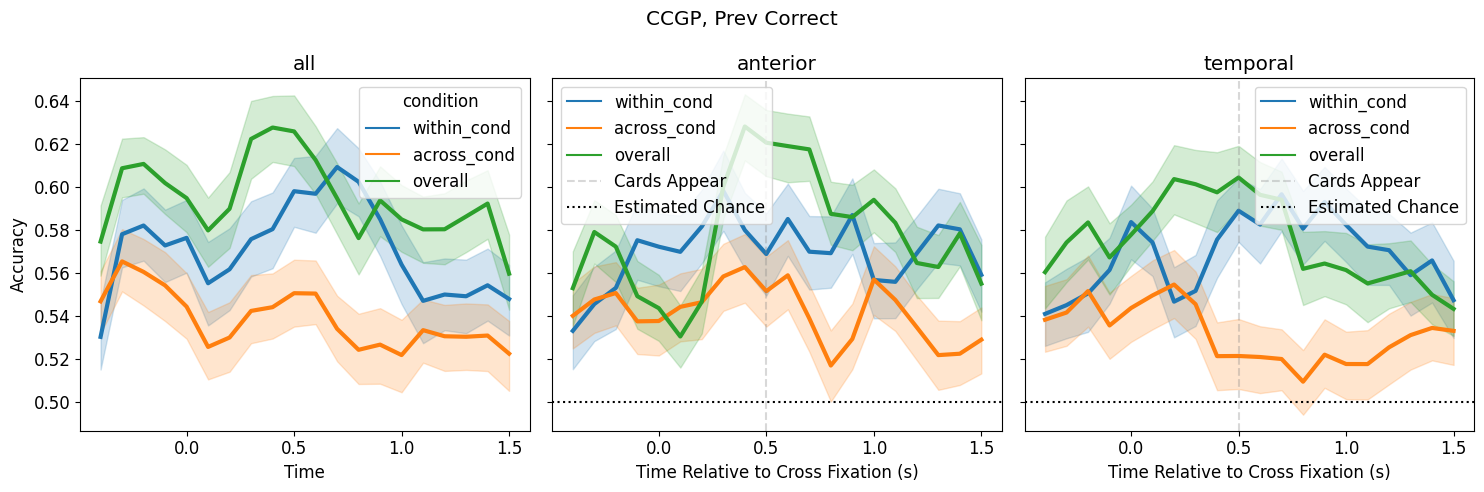

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

ax = axs[0]
sub = res[(res.region.isna()) & (res.prev_response == "Correct")]
sns.lineplot(sub, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
ax.set_title("all")

ax = axs[1]
sub = res[(res.region == "anterior") & (res.prev_response == "Correct")]
sns.lineplot(sub, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
set_labels(ax)
ax.set_title("anterior")

ax = axs[2]
sub = res[(res.region == "temporal") & (res.prev_response == "Correct")]
sns.lineplot(sub, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
set_labels(ax)
ax.set_title("temporal")

fig.suptitle("CCGP, Prev Correct")
fig.tight_layout()


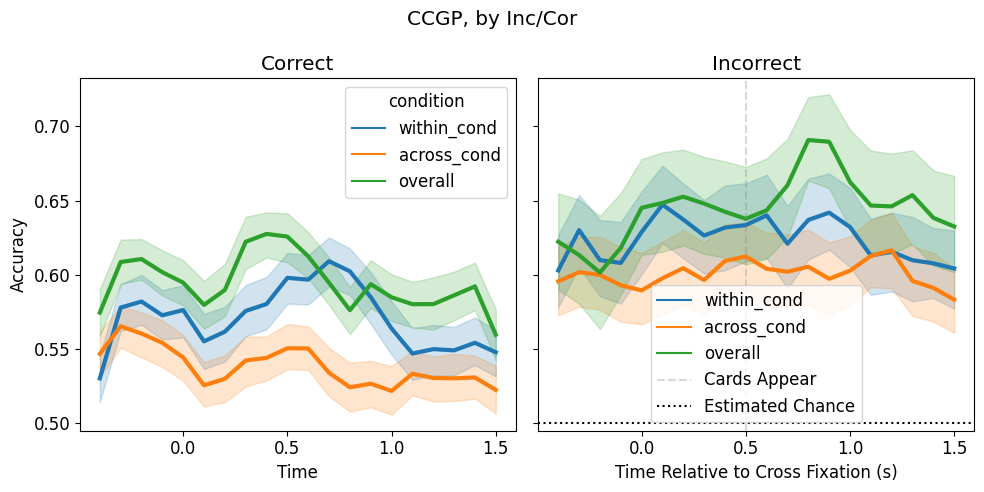

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax = axs[0]
sub = res[(res.region.isna()) & (res.prev_response == "Correct")]
sns.lineplot(sub, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
ax.set_title("Correct")

ax = axs[1]
sub = res[(res.region.isna()) & (res.prev_response == "Incorrect")]
sns.lineplot(sub, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
set_labels(ax)
ax.set_title("Incorrect")

fig.suptitle("CCGP, by Inc/Cor")
fig.tight_layout()
